In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Configuration space complexity analysis

This notebook analyzes the configuration space complexity of different real-world network service scenarios. The used scenarios are all based on [ETSI's proof of concepts (PoC)](http://www.etsi.org/technologies-clusters/technologies/nfv/nfv-poc).

The following services are analyzed:

| id | name | ETSI PoC number | link | number of involved VNFs ($n$) |
|---|---|---|---|---|
|0| firewall (baseline, single VNF) | - | - | 1 |
|1| vEPC | 5 | [link](https://nfvwiki.etsi.org/index.php?title=E2E_vEPC_Orchestration_in_a_multi-vendor_open_NFVI_environment) | 7 |
|1| vEPC (high availability (HA))| 5 | [link](https://nfvwiki.etsi.org/index.php?title=E2E_vEPC_Orchestration_in_a_multi-vendor_open_NFVI_environment) | 14 |
|3| vIMS | 11 | [link](https://nfvwiki.etsi.org/index.php?title=Multi-Vendor_on-boarding_of_vIMS_on_a_cloud_management_framework) | 5 |
|4| SGi/Gi-LAN | 15 | [link](https://nfvwiki.etsi.org/index.php?title=Subscriber_Aware_SGi/Gi-LAN_Virtualization) | 4 |
|5| VoLTE | 27 | [link](https://nfvwiki.etsi.org/index.php?title=VoLTE_Service_based_on_vEPC_and_vIMS_Architecture) | 6 |
|6| L3VPN | 36 | [link](https://nfvwiki.etsi.org/index.php?title=Active_Video_Monitoring_in_an_L3VPN) | 5 |

In [3]:
poc_services = [
    {"name": "baseline\n(single VNF)",
     "poc_id": 0,
     "n_vnfs": 1},
    {"name": "vEPC",
     "poc_id": 5,
     "n_vnfs": 7},
    {"name": "vEPC (HA)",
     "poc_id": 5,
     "n_vnfs": 14},
    {"name": "vIMS",
     "poc_id": 11,
     "n_vnfs": 5},
    {"name": "SGi/Gi-LAN",
     "poc_id": 15,
     "n_vnfs": 4},
    {"name": "VoLTE",
     "poc_id": 27,
     "n_vnfs": 6},
    {"name": "L3VPNmon",
     "poc_id": 36,
     "n_vnfs": 5},
]

## Model

We define the set of all possible configurations $F$ of a VNF as the cartesian product of a series of sets $F = P_1 \times P_2 \times ... \times P_m$ where each set represents a single, discrete configuration parameter (also called a feature) $P_i$ and its possible values, e.g., number of CPU cores: $P_{cores} = \{1, 2, ..., 8\}$. In a complex SFC, multiple VNFs are combined and each of them can be configured independently of other VNFs with a configuration $c \in F$. For simplicity of the model, we assume that every involved VNF supports all available configuration features of $F$. Based on this, the overall configuration space $C$ of a complex SFC with $n$ VNFs can be defined as $C = F_1 \times F_2 \times ... \times F_n$. Its cardinality as function of available configuration features and number of VNFs is defined as:

$|C| = \Big(\prod_{i=1}^{m}|P_i|\Big)^n$.

### Real-world estimates of $m$

We analyzed real-world descriptor and information models to find realistic values for $m$. To simplify the task, we only consider the configuration parameters for CPU and memory since these are similar accros different standards and projects. Thus, all results should be understood as a *lower bound* because additional parameters, like software configurations or versions are not considered.

#### ETSI IFA11 and TOSCA NFV v.10

ETSI [IFA11 Management and Orchestration; VNF Packaging Specification](http://www.etsi.org/deliver/etsi_gs/NFV-IFA/001_099/011/02.01.01_60/gs_NFV-IFA011v020101p.pdf) defines ETSIs VNF descriptors. Specifically Section 7.1.6 "Information elements related to the VDU". [TOSCA NFV-v1.0](http://docs.oasis-open.org/tosca/tosca-nfv/v1.0/csd03/tosca-nfv-v1.0-csd03.html) defines the same model.

| field | type | pos. values | comment | number of discrete values |
|----|----|----|----|
| cpuArchitecture | string | x86, arm | - | 2 |
| numVirutalCpu | int | 1...16 | | 16 |
| virtualCpuClock | int | 1...100 | percent (simplification) | 100 |
| virtualCpuOversubscriptionPolicy | bool | 0/1 | | 2 |
| virtualCpuPinning | bool | 0/1 || 2 |
| virutalMemSize | int | 128, 256, 512, 1024, 2048, 4096, 8129, 16384 | | 8 |
| virtualMemoryOversubscriptionPolicy | bool | 0/1 || 2 |
| numaEnabled | bool | 0/1 | | 2 |



In [4]:
etsi_m = 2 * 16 * 100 * 2 * 2 * 8 * 2 * 2
print(np.log10(etsi_m))
etsi_m

5.61235994797


409600

#### OSM hackfest example #4 (VM with EPA)

The ETSI and TOSCA models are still quite theoretic and many field are often not used. This is why we also use a real-world example from ETSI OSM Hackfest #2. This example is a VNF with guest EPA enabled.

* Example VNFD: [hackfest_4_vnfd.tar.gz](https://osm-download.etsi.org/ftp/osm-3.0-three/2nd-hackfest/packages/hackfest_4_vnfd.tar.gz)
* IM with infos about selectable values [YANG file](https://osm.etsi.org/gitweb/?p=osm/IM.git;a=tree;f=models/yang;h=638eaad487127a45844d635206aff14e7903df35;hb=HEAD)

| field | type | pos. values | comment | number of discrete values |
|----|----|----|----|
| vcpu-count | int | 1...16 | | 16
| memory-mb | int | 128, 256, 512, 1024, 2048, 4096, 8129, 16384 | | 8 |
| cpu-pinning-policy | | dedicated, shared, any || 3 |
| cpu-thread-pinning-policy | | avoid, separate isolate, prefer | | 4 |
| mempage-size | | large, small, size2mb, size1gb, prefer_large, | | 5 |
| numa-mem-policy || strict, preferred | | 2 |

In [8]:
osm_m = 16 * 8 * 3 * 4 * 5 * 2
print(np.log10(osm_m))
osm_m

4.1863912157


15360

## Analysis

In [6]:
def calc_config_no(n, m):
    return np.float64(m) ** np.float64(n)

data = list()
for poc in poc_services:
    # etsi model
    d = dict()
    d["VNF model"] = "ETSI/TOSCA"
    d["ETSI PoC"] = "{}".format(poc["name"])
    if poc["poc_id"] > 0:
        d["ETSI PoC"] = "{}\n(PoC#{})".format(poc["name"], poc["poc_id"])
    d["poc_id"] = poc["poc_id"]
    d["m"] = etsi_m
    d["conf. space size"] = calc_config_no(poc["n_vnfs"], etsi_m)
    data.append(d)
    # osm model
    d = dict()
    d["VNF model"] = "OSM rel. 3"
    d["ETSI PoC"] = "{}".format(poc["name"])
    if poc["poc_id"] > 0:
        d["ETSI PoC"] = "{}\n(PoC#{})".format(poc["name"], poc["poc_id"])
    d["poc_id"] = poc["poc_id"]
    d["m"] = osm_m
    d["conf. space size"] = calc_config_no(poc["n_vnfs"], osm_m)
    data.append(d)
    
df = pd.DataFrame(data)
df

,ETSI PoC,VNF model,conf. space size,m,poc_id
0,baseline\n(single VNF),ETSI/TOSCA,4.096000e+05,409600,0
1,baseline\n(single VNF),OSM rel. 3,1.536000e+04,15360,0
2,vEPC\n(PoC#5),ETSI/TOSCA,1.934281e+39,409600,5
3,vEPC\n(PoC#5),OSM rel. 3,2.017151e+29,15360,5
4,vEPC (HA)\n(PoC#5),ETSI/TOSCA,3.741444e+78,409600,5
5,vEPC (HA)\n(PoC#5),OSM rel. 3,4.068900e+58,15360,5
6,vIMS\n(PoC#11),ETSI/TOSCA,1.152922e+28,409600,11
7,vIMS\n(PoC#11),OSM rel. 3,8.549802e+20,15360,11
8,SGi/Gi-LAN\n(PoC#15),ETSI/TOSCA,2.814750e+22,409600,15
9,SGi/Gi-LAN\n(PoC#15),OSM rel. 3,5.566278e+16,15360,15


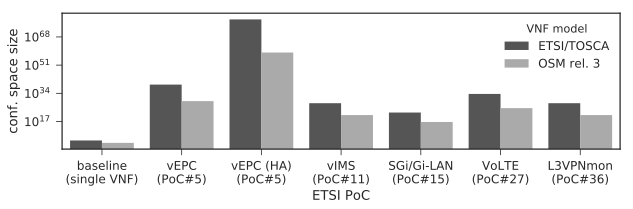

In [7]:
sns.set(rc={'figure.figsize':(10, 2.5)})
sns.set_context("paper",
                    font_scale=1.5,
                    rc={
                    "lines.linewidth": .7
                    })
sns.set_style("ticks")
g = sns.barplot(x="ETSI PoC", y="conf. space size", hue="VNF model", data=df, log=True, palette="gray")

plt.savefig("plots/etsi_tosca_osm_conf_space_analysis.pdf", bbox_inches="tight")